In [71]:
import pandas as pd
import matplotlib.pyplot as plt


In [72]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()

Dodavanje duplikata

In [73]:
author_counts = df['Autor'].value_counts()
single_instance_authors = author_counts[author_counts == 1].index

unique_authors_rows = df[df['Autor'].isin(single_instance_authors)].copy()
df = pd.concat([df, unique_authors_rows], ignore_index=True)
df['Autor'] = df['Autor'].astype('category').cat.codes


Tokenizacija reci i recenica


In [74]:
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jelenalazovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
class LangVars(PunktLanguageVars):
    sent_end_chars = ('.', '!', '?', ';', ":", "...", '..','…')
custom_sent_tokenizer = PunktSentenceTokenizer(lang_vars=LangVars())
df['Recenice'] = df['Tekst'].apply(custom_sent_tokenizer.tokenize)

In [76]:
custom_tokenizer = RegexpTokenizer(r'\w+[\'\’]*\w*|[^\w\s]')
df['Tokeni'] = df['Tekst'].apply(custom_tokenizer.tokenize)

In [77]:
punctuation = r'[^\w\s]'
def remove_punctuation(tokens): 
    filtered_tokens = [word for word in tokens if not re.match(punctuation, word)]
    return filtered_tokens

df['Filtrirani tokeni'] = df['Tokeni'].apply(remove_punctuation)

In [78]:
from nltk import FreqDist

In [79]:
all_words = [word for words in df['Filtrirani tokeni'] for word in words]
fdist = FreqDist(all_words)
stopwords = [word for word, count in fdist.items() if count > 50 or (len(word) in (1,2,3) and count > 20)]

In [80]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens

#df['Filtrirani tokeni'] = df['Filtrirani tokeni'].apply(remove_stopwords)

Podela podataka na trening i test

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X = df[['Tekst', 'Recenice', 'Tokeni','Filtrirani tokeni']]
y = df['Autor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Stilometrijske analize

In [83]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [84]:
def average_word_length(words):
    return sum(len(word) for word in words) / len(words)

df_train['Duzina reci'] = df_train['Filtrirani tokeni'].apply(average_word_length)
df_test['Duzina reci'] = df_test['Filtrirani tokeni'].apply(average_word_length)


In [85]:
df_avgWordLength = df_train.groupby('Autor')['Duzina reci'].mean().reset_index()

In [86]:
import matplotlib.pyplot as plt


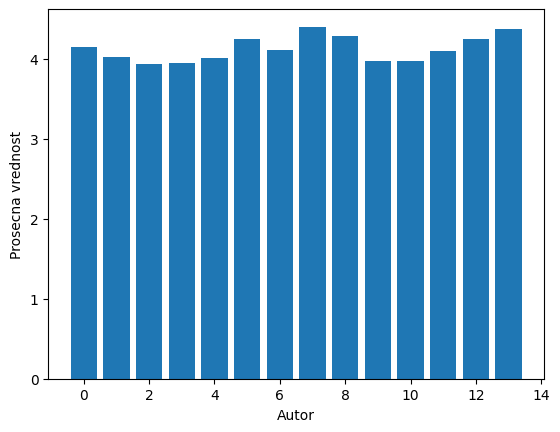

In [87]:
plt.bar(df_avgWordLength['Autor'], df_avgWordLength['Duzina reci'])
plt.xlabel('Autor')
plt.ylabel('Prosecna vrednost')
plt.show()

In [88]:
def average_sentence_length(sentences):
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

df_train['Duzina recenica'] = df_train['Recenice'].apply(average_sentence_length)
df_test['Duzina recenica'] = df_test['Recenice'].apply(average_sentence_length)


In [89]:
df_avgSentLength = df_train.groupby('Autor')['Duzina recenica'].mean().reset_index()


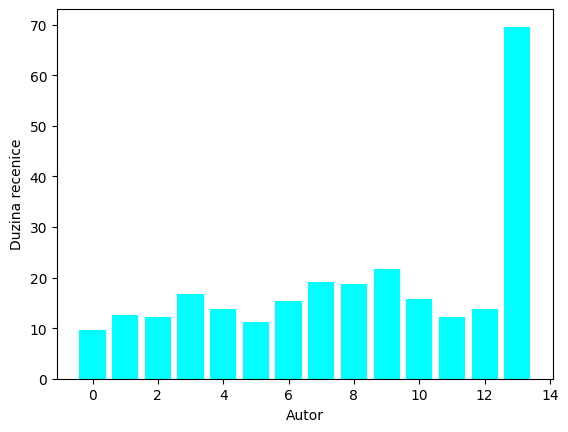

In [90]:
plt.bar(df_avgSentLength['Autor'], df_avgSentLength['Duzina recenica'], color='cyan')
plt.xlabel('Autor')
plt.ylabel('Duzina recenice')
plt.show()

In [91]:
def text_length(words):
    return sum(len(word) for word in words)
df_train['Duzina teksta'] = df_train['Tokeni'].apply(text_length)
df_test['Duzina teksta'] = df_test['Tokeni'].apply(text_length)

In [92]:
df_avgTextLength = df_train.groupby('Autor')['Duzina teksta'].mean().reset_index()


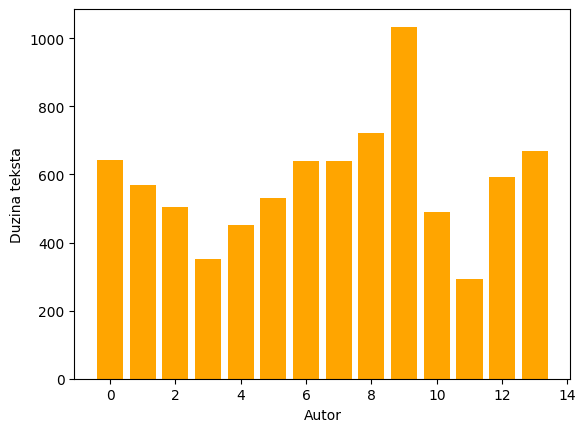

In [93]:
plt.bar(df_avgTextLength['Autor'], df_avgTextLength['Duzina teksta'], color='orange')
plt.xlabel('Autor')
plt.ylabel('Duzina teksta')
plt.show()

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(max_depth=5,min_samples_split=15, n_estimators=300)
model.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']],df_train['Autor'])
y_pred = model.predict(df_test[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])
report = accuracy_score(df_test['Autor'], y_pred)
report

0.2619047619047619

In [95]:
from sklearn.naive_bayes import MultinomialNB

classifierMB = MultinomialNB()
#df_random = pd.DataFrame(X_train.toarray(), columns= vectorizer.get_feature_names_out())
classifierMB.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']],df_train['Autor'])
y_pred = classifierMB.predict(df_test[['Duzina reci','Duzina recenica', 'Duzina teksta']])
report = accuracy_score(df_test['Autor'], y_pred)
report

0.14285714285714285

In [100]:
import classla
from collections import Counter

classla.download('sr')

# Initialize the Classla pipeline for Serbian
pipeline = classla.Pipeline('sr', processors='tokenize,pos')



def count_pos_categories(text):
    # Process the text using the Classla pipeline
    doc = pipeline(text)

    # Extract the POS tags from the processed text and categorize them
    pos_tags = [word.xpos for sent in doc.sentences for word in sent.words]

    # Count the occurrences of each POS category
    pos_category_counts = Counter(pos_tags)

    return pos_category_counts


# Apply the count_pos_categories function to each row in the DataFrame
df_train['POS_Counts'] = df_train['Tekst'].apply(count_pos_categories)
df_test['POS_Counts'] = df_test['Tekst'].apply(count_pos_categories)



df_pos = df_train.groupby('Autor')['POS_Counts'].sum().reset_index()


2023-12-26 17:03:58 INFO: Downloading these customized packages for language: sr (Serbian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2023-12-26 17:03:58 INFO: File exists: /Users/jelenalazovic/classla_resources/sr/pos/standard.pt.
2023-12-26 17:04:00 INFO: File exists: /Users/jelenalazovic/classla_resources/sr/lemma/standard.pt.
2023-12-26 17:04:00 INFO: File exists: /Users/jelenalazovic/classla_resources/sr/depparse/standard.pt.
2023-12-26 17:04:00 INFO: File exists: /Users/jelenalazovic/classla_resources/sr/ner/standard.pt.
2023-12-26 17:04:01 INFO: File exists: /Users/jelenalazovic/classla_resources/sr/pretrain/standard.pt.
2023-12-26 17:04:01 INFO: Finished downloading models and saved to /Users/jelenalazovic/classla_resources.
2023-12-26 17:04:01 INFO: Loading these models for language: sr (Serbian):
| Processor | Package